<a href="https://colab.research.google.com/github/anasCSD/Glaucoma-Classification/blob/main/MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print("Pytorch version:", torch.__version__)

Pytorch version: 2.9.0+cu126


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [ ]:
%pip install ipython-autotime
%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.1 MB/s eta 0:00:00
time: 213 µs (started: 2025-11-27 13:23:06 +00:00)


In [ ]:
!pip install torchinfo

time: 9.78 s (started: 2025-11-27 13:23:07 +00:00)


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import os
import random
import shutil
import PIL as pil
import cv2
import matplotlib as mpl
import tqdm
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

time: 11.8 s (started: 2025-11-27 13:23:18 +00:00)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 24.2 s (started: 2025-11-27 13:23:32 +00:00)


In [ ]:
base_url = '/content/drive/MyDrive/Research'

batch_size = 4
img_height = 224
img_width = 224

class_names = ['glaucoma', 'normal']

time: 496 µs (started: 2025-11-27 13:23:58 +00:00)


In [ ]:
def model_summary(model:torch.nn.Module,
                  input_size:tuple):
  return summary(model=model,
                input_size=input_size,
                col_names=["input_size", "output_size", "num_params", "trainable"],
                col_width=20,
                row_settings=['var_names'])

time: 597 µs (started: 2025-11-27 13:24:00 +00:00)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor()
])

dataset_url = '/content/drive/MyDrive/Research/Glaucoma_Splitted'

train_path = f'{dataset_url}/train'
valid_path = f'{dataset_url}/val'
test_path = f'{dataset_url}/test'

train_ds = datasets.ImageFolder(root=train_path, transform=transform)
valid_ds = datasets.ImageFolder(root=valid_path, transform=transform)
test_ds = datasets.ImageFolder(root=test_path, transform=transform)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, num_workers=0,
                                          shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, num_workers=0,
                                          shuffle=False)

test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, num_workers=0,
                                         shuffle=False)

time: 6.81 s (started: 2025-11-27 13:24:02 +00:00)


In [ ]:
num_classes = 2

# Load pretrained MobileNetV2
model = torchvision.models.mobilenet_v2(weights="DEFAULT")


for param in model.parameters():
    param.requires_grad = False


num_features = model.classifier[1].in_features     #  1280

#  custom classifier
custom_classifier = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),

    nn.Linear(1024, 512),
    nn.ReLU(),

    nn.Flatten(),
    nn.Linear(512, num_classes)
)


model.classifier = custom_classifier


model_summary(
    model=model,
    input_size=(4, 3, 224, 224)
)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 128MB/s]


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MobileNetV2 (MobileNetV2)                     [4, 3, 224, 224]     [4, 2]               --                   Partial
├─Sequential (features)                       [4, 3, 224, 224]     [4, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)               [4, 3, 224, 224]     [4, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                        [4, 3, 224, 224]     [4, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                   [4, 32, 112, 112]    [4, 32, 112, 112]    (64)                 False
│    │    └─ReLU6 (2)                         [4, 32, 112, 112]    [4, 32, 112, 112]    --                   --
│    └─InvertedResidual (1)                   [4, 32, 112, 112]    [4, 16, 112, 112]    --                   False
│    │    └─Sequential (conv)                 [4, 32, 112, 112]    [4, 16, 11

time: 1.5 s (started: 2025-11-27 13:24:11 +00:00)


In [ ]:
params_to_train =  model.classifier.parameters()

model = model.to(device)

learning_rate = 0.00001
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_train, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')



time: 5.47 ms (started: 2025-11-27 13:24:17 +00:00)


In [ ]:
filepath = f'{base_url}/Results/MobileNetV2/model.pth'
print(os.path.exists(filepath))

False
time: 7 ms (started: 2025-11-27 13:40:17 +00:00)


In [ ]:
def evaluate(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / len(data_loader)
    accuracy = correct / total

    return loss, accuracy

time: 884 µs (started: 2025-11-27 13:24:30 +00:00)


In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):

    # History lists to store curves
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        # Validation check
        val_loss, val_accuracy = evaluate(model, val_loader, criterion)

        # Store in history
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            torch.save(model.state_dict(), filepath)
            print(f"Model weights saved to {filepath}")
            best_val_loss = val_loss

    # Return history for plotting
    return train_losses, val_losses, train_accuracies, val_accuracies


time: 1.45 ms (started: 2025-11-27 13:24:36 +00:00)


In [ ]:
train_losses, val_losses, train_acc, val_acc = train(
    model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs
)


Epoch 1/50, Train Loss: 0.5145, Train Accuracy: 0.7801, Val Loss: 0.5044, Val Accuracy: 0.7775
Model weights saved to /content/drive/MyDrive/Research/Results/MobileNetV2/model.pth
Epoch 2/50, Train Loss: 0.5062, Train Accuracy: 0.7801, Val Loss: 0.4974, Val Accuracy: 0.7775
Model weights saved to /content/drive/MyDrive/Research/Results/MobileNetV2/model.pth
Epoch 3/50, Train Loss: 0.4932, Train Accuracy: 0.7801, Val Loss: 0.4922, Val Accuracy: 0.7775
Model weights saved to /content/drive/MyDrive/Research/Results/MobileNetV2/model.pth
Epoch 4/50, Train Loss: 0.4913, Train Accuracy: 0.7801, Val Loss: 0.4920, Val Accuracy: 0.7775
Model weights saved to /content/drive/MyDrive/Research/Results/MobileNetV2/model.pth
Epoch 5/50, Train Loss: 0.4892, Train Accuracy: 0.7812, Val Loss: 0.4867, Val Accuracy: 0.7775
Model weights saved to /content/drive/MyDrive/Research/Results/MobileNetV2/model.pth
Epoch 6/50, Train Loss: 0.4760, Train Accuracy: 0.7812, Val Loss: 0.4918, Val Accuracy: 0.7775
Epoch

In [ ]:
def plot_loss_curve(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


time: 727 µs (started: 2025-11-27 16:04:26 +00:00)


In [ ]:
def plot_accuracy_curve(train_acc, val_acc):
    plt.figure(figsize=(10, 6))
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


time: 670 µs (started: 2025-11-27 16:04:29 +00:00)


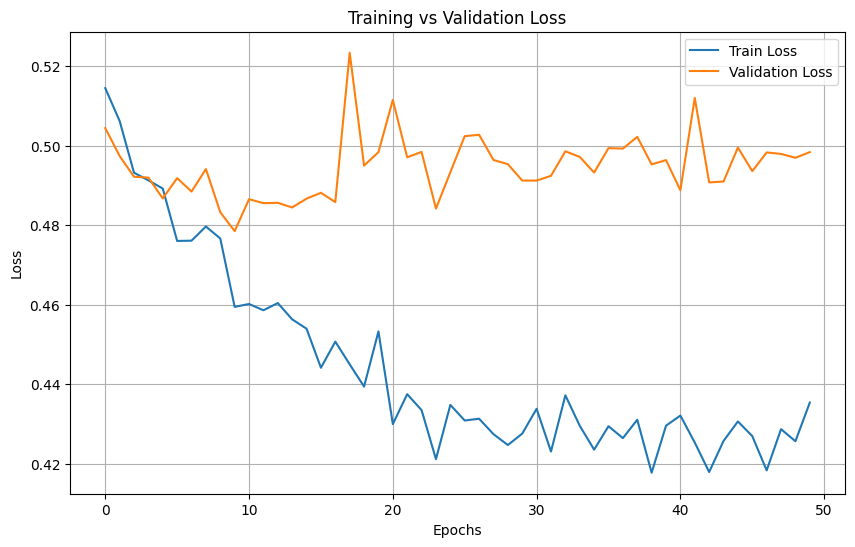

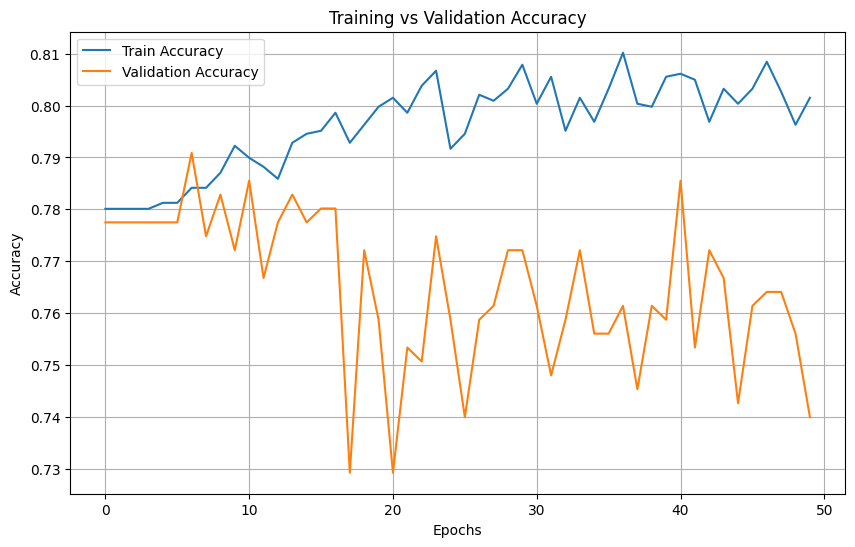

time: 357 ms (started: 2025-11-27 16:04:31 +00:00)


In [ ]:
plot_loss_curve(train_losses, val_losses)
plot_accuracy_curve(train_acc, val_acc)

In [ ]:
model.load_state_dict(torch.load(filepath))
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

time: 125 ms (started: 2025-11-27 16:04:57 +00:00)


In [ ]:
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.4961, Test Accuracy: 0.7649
time: 3min 17s (started: 2025-11-27 16:05:19 +00:00)


In [ ]:
train_loss, train_accuracy = evaluate(model, train_loader, criterion)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

Train Loss: 0.4488, Train Accuracy: 0.7946
time: 2min 21s (started: 2025-11-27 16:08:43 +00:00)


In [ ]:
val_loss, val_accuracy = evaluate(model, valid_loader, criterion)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Validation Loss: 0.4785, Validation Accuracy: 0.7721
time: 31.3 s (started: 2025-11-27 16:11:10 +00:00)


In [ ]:
def plot_confusion_matrix(model, dataloader, class_names, title="Confusion Matrix"):
    model.eval()
    all_actual = []
    all_predicted = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_actual.extend(labels.cpu().numpy())
            all_predicted.extend(preds.cpu().numpy())

    all_actual = np.array(all_actual)
    all_predicted = np.array(all_predicted)

    cm = confusion_matrix(all_actual, all_predicted)
    print(f"\n{title}:\n", cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

    return cm

time: 1.12 ms (started: 2025-11-27 16:11:46 +00:00)



Training Confusion Matrix:
 [[  35  345]
 [  10 1338]]


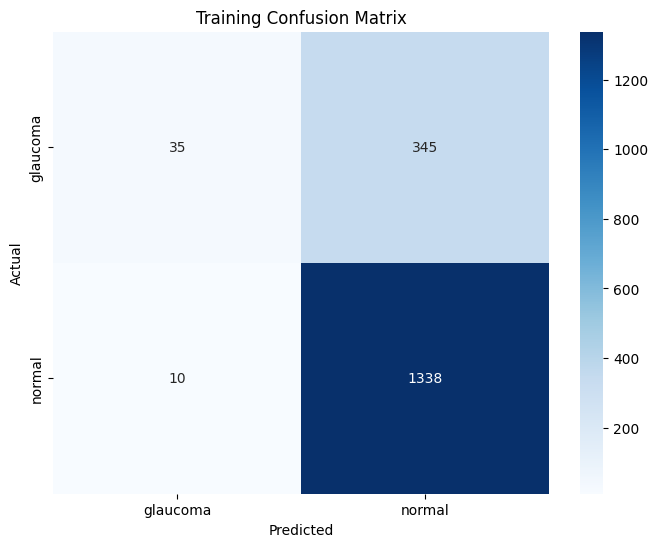

array([[  35,  345],
       [  10, 1338]])

time: 2min 21s (started: 2025-11-27 16:11:50 +00:00)


In [ ]:
plot_confusion_matrix(model, train_loader, class_names, title="Training Confusion Matrix")


Test Confusion Matrix:
 [[  2  79]
 [  8 281]]


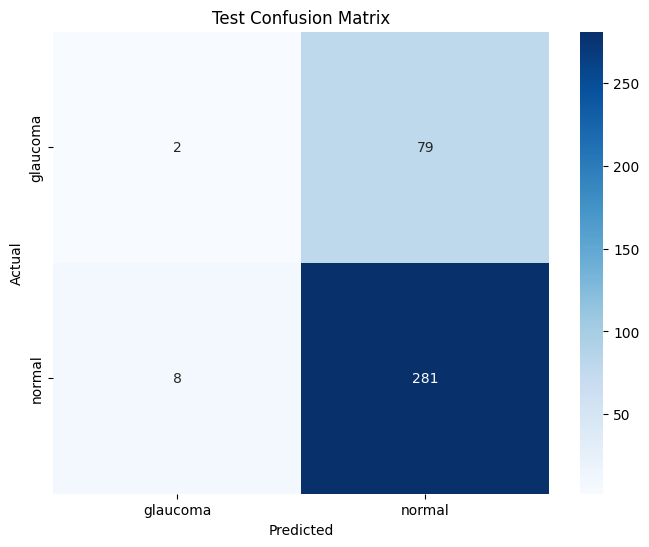

array([[  2,  79],
       [  8, 281]])

time: 29.6 s (started: 2025-11-27 16:14:45 +00:00)


In [ ]:
plot_confusion_matrix(model, test_loader, class_names, title="Test Confusion Matrix")


Validation Confusion Matrix:
 [[  6  77]
 [  8 282]]


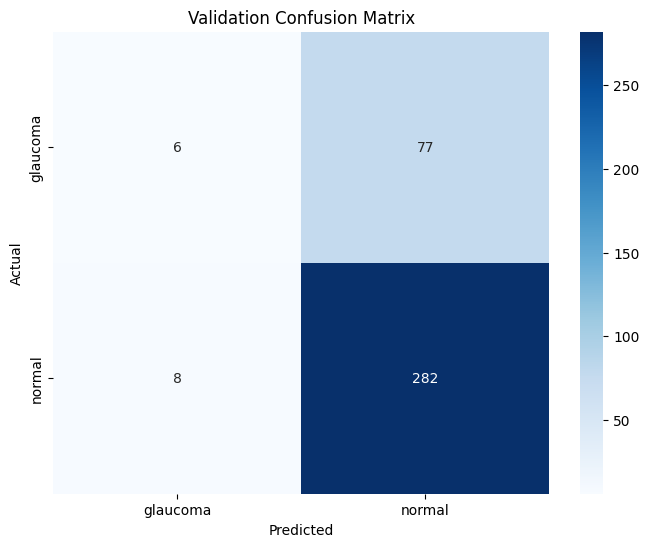

array([[  6,  77],
       [  8, 282]])

time: 30.3 s (started: 2025-11-27 16:15:57 +00:00)


In [ ]:
plot_confusion_matrix(model, valid_loader, class_names, title="Validation Confusion Matrix")

In [ ]:
def plot_roc_curve(model, test_loader, class_names):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            probs = torch.softmax(outputs, dim=1)  # convert logits → probabilities

            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())   # shape (batch,2)

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # ---- Manual 2-column binarize ----
    y_true_bin = np.zeros((len(y_true), len(class_names)))
    for idx, lab in enumerate(y_true):
        y_true_bin[idx, lab] = 1
    # ----------------------------------

    plt.figure(figsize=(10, 8))

    for i, name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)

        print(f"Class {name} ROC AUC: {roc_auc:.3f}")
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (DenseNet121)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

time: 8.18 ms (started: 2025-11-27 16:17:08 +00:00)


Class glaucoma ROC AUC: 0.665
Class normal ROC AUC: 0.665


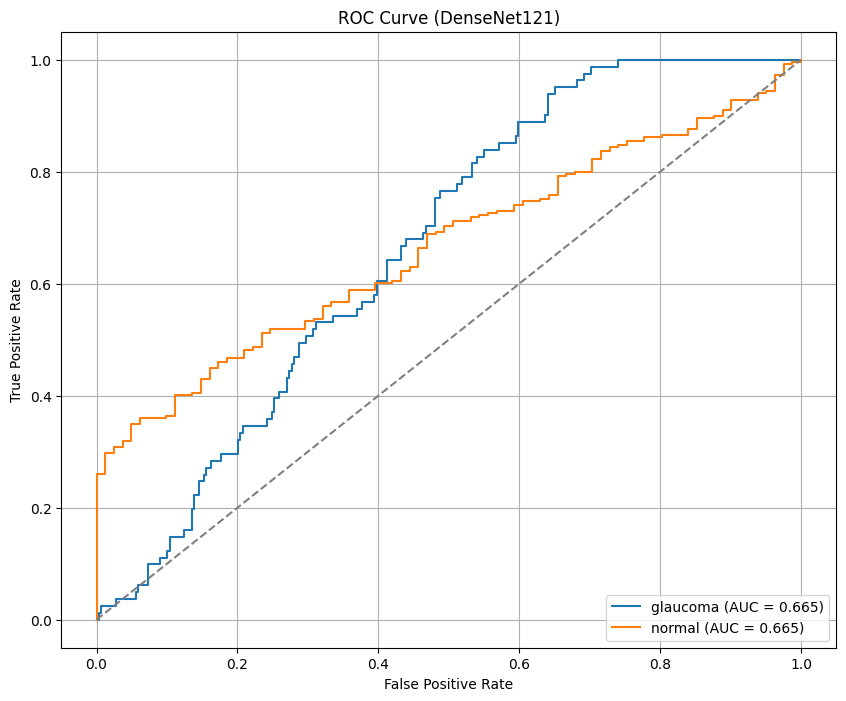

time: 31 s (started: 2025-11-27 16:17:24 +00:00)


In [ ]:
plot_roc_curve(model, test_loader, class_names)

Class glaucoma ROC AUC: 0.709
Class normal ROC AUC: 0.709


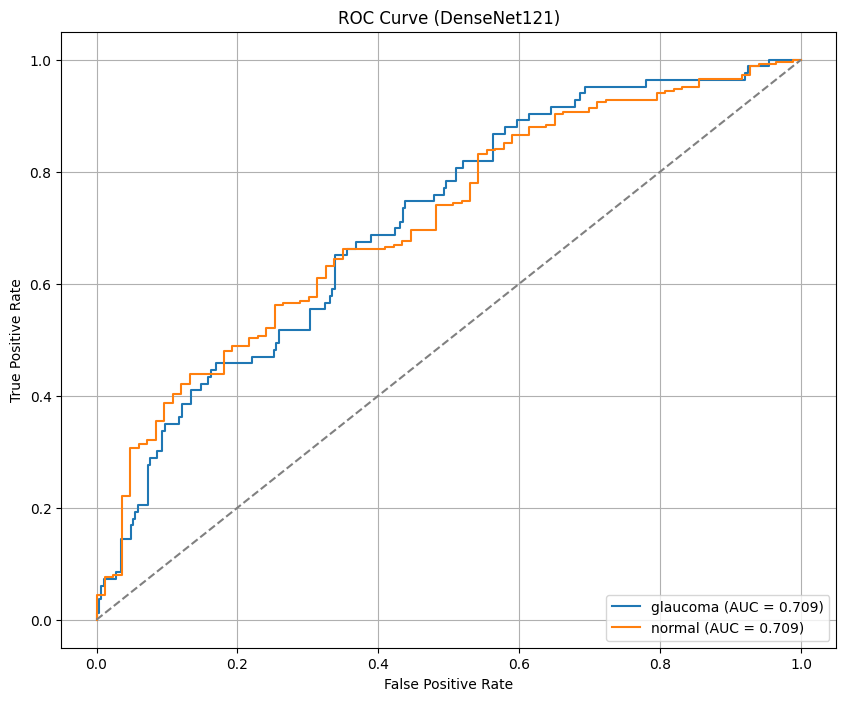

time: 33.2 s (started: 2025-11-27 16:18:00 +00:00)


In [ ]:
plot_roc_curve(model, valid_loader, class_names)

Class glaucoma ROC AUC: 0.766
Class normal ROC AUC: 0.766


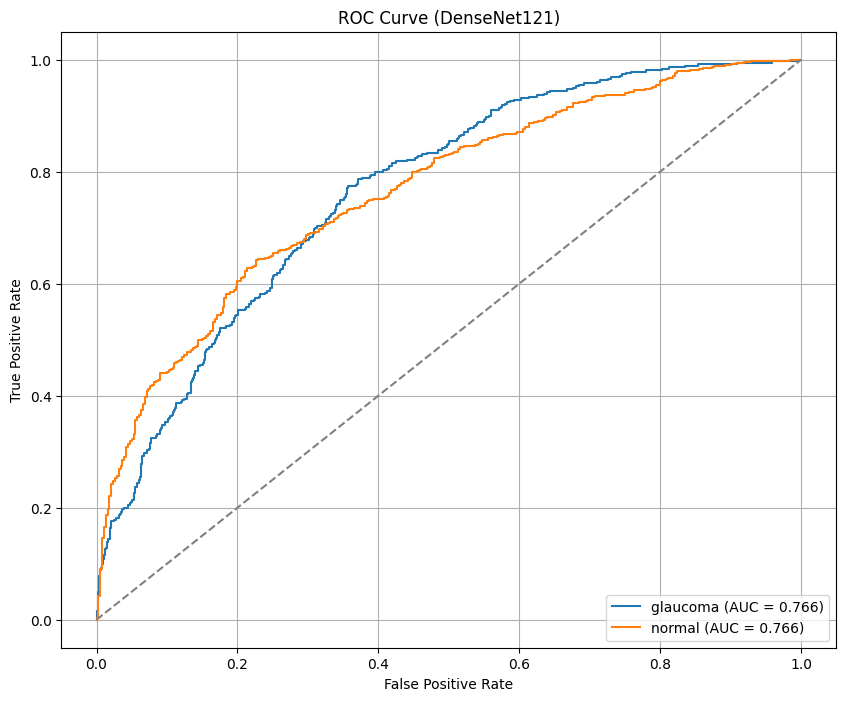

time: 2min 23s (started: 2025-11-27 16:18:44 +00:00)


In [ ]:
plot_roc_curve(model, train_loader, class_names)